In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

import random
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
from keras import optimizers
from matplotlib import pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# Any results you write to the current directory are saved as output.

['train', 'test']


Using TensorFlow backend.


In [2]:
np.random.seed(42)

### Data processing

In [3]:
base_dir = '../input'
train_dir = os.path.join(base_dir, 'train/')
test_dir = os.path.join(base_dir, 'test/')

In [4]:
ROWS = 150
COLS = 150
CHANNELS = 3
IMG_SIZE = (150, 150)
BATCH_SIZE=128

####  slice datasets for memory efficiency on Kaggle Kernels


In [5]:
original_train_images_prep = [test_dir+i for i in os.listdir(train_dir)]


train_dogs =   [train_dir+i for i in os.listdir(train_dir) if 'dog' in i]
train_cats =   [train_dir+i for i in os.listdir(train_dir) if 'cat' in i]

In [6]:
len(original_train_images_prep)

25000

In [7]:
train_cats[:5], train_dogs[:5]

(['../input/train/cat.11679.jpg',
  '../input/train/cat.8233.jpg',
  '../input/train/cat.1653.jpg',
  '../input/train/cat.12144.jpg',
  '../input/train/cat.2354.jpg'],
 ['../input/train/dog.2811.jpg',
  '../input/train/dog.2578.jpg',
  '../input/train/dog.9238.jpg',
  '../input/train/dog.7504.jpg',
  '../input/train/dog.11302.jpg'])

In [8]:
test_images =  [test_dir+i for i in os.listdir(test_dir)]
test_images[:5]

['../input/test/3090.jpg',
 '../input/test/8785.jpg',
 '../input/test/10679.jpg',
 '../input/test/7247.jpg',
 '../input/test/8151.jpg']

In [9]:
original_train_images = train_dogs[:1000] + train_cats[:1000]
random.shuffle(original_train_images)


In [10]:
original_train_images[:5]

['../input/train/dog.6056.jpg',
 '../input/train/dog.5563.jpg',
 '../input/train/cat.2129.jpg',
 '../input/train/dog.5646.jpg',
 '../input/train/dog.6296.jpg']

In [11]:
train_images = original_train_images#[:1800]
validation_images = original_train_images#[1800:3600]

In [12]:
def plot_arr(arr):
    plt.figure()
    plt.imshow(image.array_to_img(arr))
    plt.show()

def plot(img):
    plt.figure()
    plt.imshow(img)
    plt.show()

In [13]:
def prep_data(images):
    '''
    Create zeros matrix (count, ROWS, COLS, CHANNELS)
    
    convert every image into (ROWS, COLS, CHANNELS) and insert into zeros martix
    '''
    count = len(images)
    X = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.float32)
    y = np.zeros((count,), dtype=np.float32)
    #print(X.shape, len(y))
    for i, image_file in enumerate(images):
        img = image.load_img(image_file, target_size=(ROWS, COLS))
        X[i] = image.img_to_array(img)
        if 'dog' in image_file:
            y[i] = 1.
        if i%1000 == 0: print('Processed {} of {}'.format(i, count))
    
    return X, y
    

In [14]:
X_train, y_train = prep_data(train_images)

Processed 0 of 2000
Processed 1000 of 2000


In [15]:
X_train.shape

(2000, 150, 150, 3)

In [16]:
X_validation, y_validation = prep_data(validation_images)

Processed 0 of 2000
Processed 1000 of 2000


### Data Augmentation

In [17]:
train_datagen = image.ImageDataGenerator(rescale=1./255,
                                  rotation_range=70,
                                  #width_shift_range=0.5,
                                  #shear_range=0.5,
                                  #zoom_range=0.2,
                                  horizontal_flip=True)

valid_datagen = image.ImageDataGenerator(rescale=1./255)

In [18]:
train_gen = train_datagen.flow(X_train,
                               y_train,
                               batch_size=BATCH_SIZE
                              )

valid_gen = train_datagen.flow(X_validation, 
                               y_validation,
                               batch_size=BATCH_SIZE
                              )

### Load vgg16 for transfer learning

In [19]:
base_model = VGG16(include_top = False,
                   weights = 'imagenet',
                   input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3))

58892288/58889256 [==============================] - 1s 0us/step


In [20]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

### add clasification layers for binary classification

In [21]:
x = base_model.layers[-2].output
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dense(1,  # один выход
                activation='sigmoid',  # функция активации  
                kernel_regularizer=keras.regularizers.l1(1e-4))(x)
#x = keras.layers.Desnse()
model = Model(inputs=base_model.input, outputs=x)

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [23]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [24]:
train_steps = len(train_images)/BATCH_SIZE
validation_steps = len(validation_images)/BATCH_SIZE


### Train model

In [25]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch=train_steps,
    epochs=10,
    validation_data=valid_gen,
    validation_steps=validation_steps,
    verbose=2)

Epoch 1/10
16/16 [==============================] - 15s 922ms/step - loss: 0.7368 - acc: 0.6485
 - 26s - loss: 4.5627 - acc: 0.5045 - val_loss: 0.7368 - val_acc: 0.6485
Epoch 2/10
16/16 [==============================] - 15s 909ms/step - loss: 0.5060 - acc: 0.7710
 - 19s - loss: 1.3733 - acc: 0.6470 - val_loss: 0.5060 - val_acc: 0.7710
Epoch 3/10
16/16 [==============================] - 15s 910ms/step - loss: 0.6059 - acc: 0.6215
 - 19s - loss: 0.7336 - acc: 0.7070 - val_loss: 0.6059 - val_acc: 0.6215
Epoch 4/10
16/16 [==============================] - 15s 907ms/step - loss: 0.3829 - acc: 0.8260
 - 19s - loss: 0.5302 - acc: 0.7735 - val_loss: 0.3829 - val_acc: 0.8260
Epoch 5/10
16/16 [==============================] - 15s 910ms/step - loss: 0.3456 - acc: 0.8420
 - 19s - loss: 0.4486 - acc: 0.7920 - val_loss: 0.3456 - val_acc: 0.8420
Epoch 6/10
16/16 [==============================] - 15s 910ms/step - loss: 0.3213 - acc: 0.8595
 - 19s - loss: 0.3950 - acc: 0.8215 - val_loss: 0.3213 - va

In [26]:
X_test, _ = prep_data(test_images)
X_test /= 255.

Processed 0 of 12500
Processed 1000 of 12500
Processed 2000 of 12500
Processed 3000 of 12500
Processed 4000 of 12500
Processed 5000 of 12500
Processed 6000 of 12500
Processed 7000 of 12500
Processed 8000 of 12500
Processed 9000 of 12500
Processed 10000 of 12500
Processed 11000 of 12500
Processed 12000 of 12500


### evaluate model

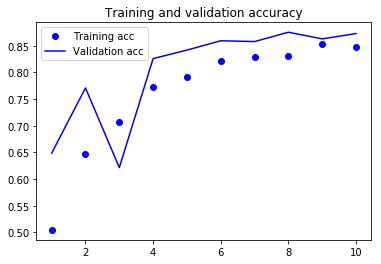

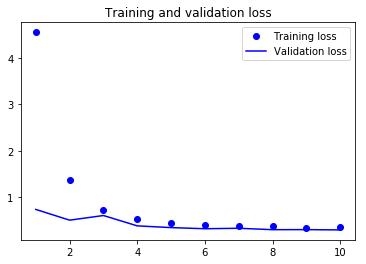

In [27]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [28]:
predictions = model.predict(X_test)

I am 95.64% sure this is a Cat


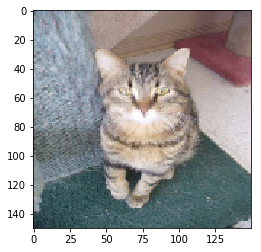

I am 97.61% sure this is a Cat


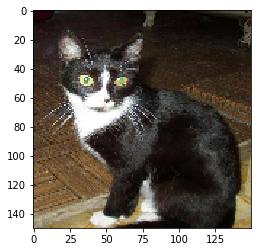

I am 95.53% sure this is a Cat


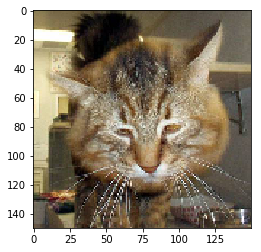

I am 90.19% sure this is a Dog


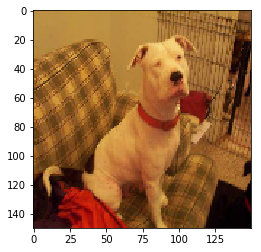

I am 97.68% sure this is a Cat


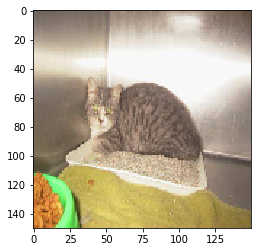

I am 98.17% sure this is a Dog


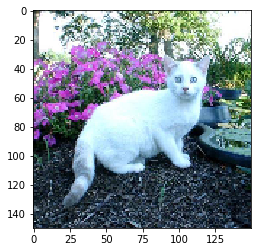

I am 91.73% sure this is a Dog


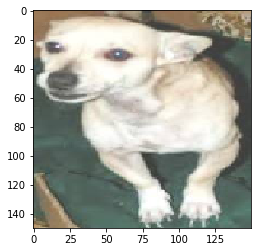

I am 99.82% sure this is a Dog


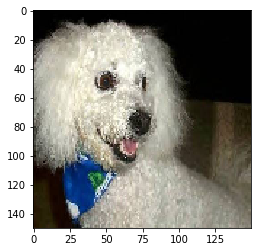

I am 98.52% sure this is a Dog


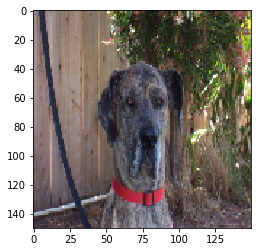

I am 100.00% sure this is a Dog


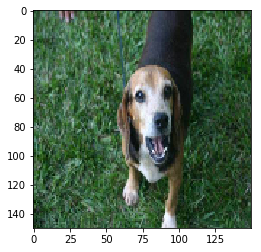

In [29]:
for i in range(0,10):
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))

    plt.imshow(image.array_to_img(X_test[i]))
    plt.show()

In [30]:
model.save('dogs-v-cat-data-augmentation-04-vgg16.h5')

### create submition

In [31]:
import csv

In [32]:
with open('dogs-v-cat-data-augmentation-04-results.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',',
                        quotechar='|', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['id', 'label'])
    for i, path in enumerate(test_images):
        basename = os.path.basename(path)
        name = os.path.splitext(basename)[0]
        writer.writerow([name, predictions[i, 0]])